# Projeto I - Computação Centífica II
### Solução de EDOs
> Autor: Gil Miranda<br>
> Contato: gil.neto@ufrj.br<br>
> Repo: [@mirandagil](https://github.com/mirandagil)<br>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as plt_color

### Encontrando a solução da EDO - refazer

$$\frac{\mathrm{d}u}{\mathrm{d}t} = Au + b$$
Como é uma equação separável, podemos resolver da seguinte forma:
$$
\begin{align}
\frac{\mathrm{d}u}{Au + b} &= \mathrm{d}t\\
\int \frac{\mathrm{d}u}{Au + b} &= \int \mathrm{d}t\\
ln(Au+b)&= A(t+c)\\
Au &= C_0 e^{At} - b\\
u &= \frac{C_0 e^{At}}{A} - \frac{b}{A}\\
\text{Mas como A é uma matriz, a solução terá a forma}\\
u(t) &= A^{-1} C_0 e^{At} - A^{-1} b\\
\text{Para descobrirmos $C_0$}\\
u(0) &= A^{-1} C_0 e^{0} - A^{-1} b\\
C_0 &= Au_0 + b
\end{align}
$$

$$
    u(t) = e^{At}u_0+ A^{-1} (e^{At}-I)g
$$

### Verificando sanidade das matrizes

In [2]:
def verifica_defeituosa(A): ## input: A -> Matriz
    def cauchy_schwarz(u,v): ## input: u - vetor nx1, v -> vetor nx1
        norm_u = np.linalg.norm(u)
        norm_v = np.linalg.norm(v)
        scalar_product = np.dot(u,v)
        if abs(scalar_product) == abs(norm_u * norm_v):
            return 1
        else:
            return 0

    M_eigen_vects = np.linalg.eig(A)[1] ## Retorna a matriz de autovetores em forma de coluna
    eigen_vects = [M_eigen_vects[:,i] for i in range(0,M_eigen_vects.shape[1])] ## Retorna cada autovetor como um vetor linha
    for i in range(0, len(eigen_vects)):
        for j in range(1,len(eigen_vects)):
            if i != j:
                if cauchy_schwarz(eigen_vects[i],eigen_vects[j]):
                    return 1
                    break
    return 0

Caso matriz diagonalizavel
$$e^{At} = Se^{\Lambda t} S^{-1} $$

In [3]:
def e_to_diag(A, t):
    eigen = np.linalg.eig(A) 
    M_eigen_vects = eigen[1] ## Retorna a matriz de autovetores em forma de coluna
    eigen_values= eigen[0]*t
    e_to = np.e**eigen_values
    diag_A = np.diag(e_to)
    inv_M = np.linalg.inv(M_eigen_vects)
    return  M_eigen_vects @ (diag_A) @ inv_M

Caso matriz defeituosa
$$
e^{At} = I + \frac{At}{1!} + \frac{A^2t^2}{2!} +\frac{A^3t^3}{3} +\frac{A^4t^4}{4!} + \dots
$$

In [4]:
def e_to_defect(A, t, termo = 10):
    I = np.identity(np.shape(A)[0])
    #e_to = I + A*t + A@A * t**2/2 + (A@A@A) * t**3 /6 + (A@A@A@A) * t**4 /24 + (A@A@A@A@A) *t**5/120 +(A@A@A@A@A@A) *t**6/720 
    e_to = I
    for i in range(1,termo):
        e_to += np.linalg.matrix_power(A*t, i)/np.math.factorial(i)
    return e_to

### Solver para ED

In [5]:
def ed_solver(A, b, c, ts):
    is_defect = verifica_defeituosa(A)
    I = np.identity(np.shape(A)[0])
    sol = [c]
    b_zero = not np.all(b)
    if b_zero:
        for t in ts:
            if is_defect:
                e_to_A = e_to_defect(A, t)
            else:
                e_to_A = e_to_diag(A,t)
            u_n = e_to_A@c
            sol.append(u_n)
    else:
        try:
            A_inv = np.linalg.inv(A)
            for t in ts:
                if is_defect:
                    e_to_A = e_to_defect(A, t)
                else:
                    e_to_A = e_to_diag(A,t)
                u_n = e_to_A@c + A_inv@(e_to_A-I)@b
                sol.append(u_n)
        except:
            print("A matriz A não é inversível, e portanto o problema não tem solução pois b é não nulo.")
    return np.array(sol)

### Função para exibir solução de uma edo dada a partir de uma Matriz

In [6]:
def exibe_solucao_1(A, b, c, tf = 10):
    ts = np.arange(0, tf, 0.1)
    sol = ed_solver(A, b, c, ts)
    sol = sol[1:]
    sol_T = sol.T
    i = 0
    plt.figure(figsize = (10,5))
    for s in sol_T:
        i += 1
        plt.plot(ts, s, label = '$x_'+ str(i) + '$')
    plt.legend(bbox_to_anchor = (1,1))
    plt.title('Solução da Equação Diferencial Matricial', fontweight = 'bold')
    plt.xlabel('tempo (t)')
    plt.grid(alpha=0.3)
    plt.show()

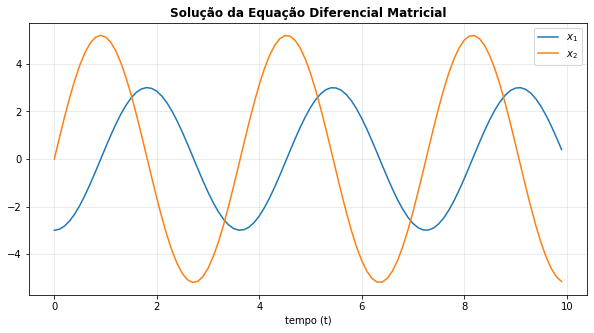

In [18]:
ts = np.arange(0,30,0.05)
A = np.array([[0,1],[-3,0]])
b = [0,0]
c = [-3,0]
exibe_solucao_1(A, b, c)


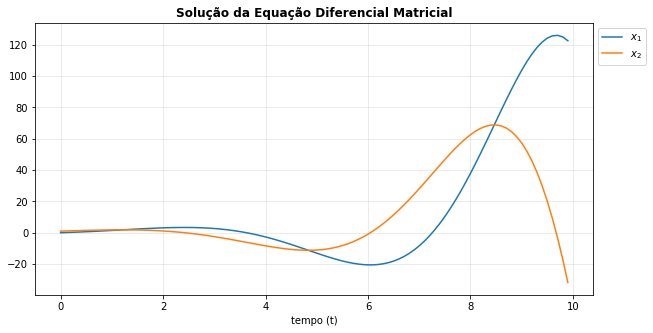

In [19]:
ts = np.arange(0,30,0.05)
A = np.array([[0,1],[-1,1]])
b = [0,-1]
c = [0,1]
exibe_solucao_1(A, b, c)


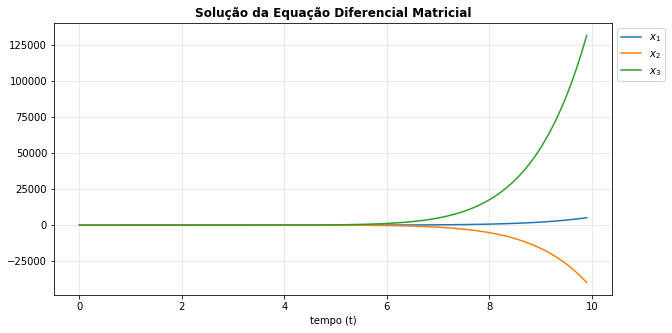

In [29]:
B = np.array([[-1,0,0],[1,-1,0],[0,1,-1]])
exibe_solucao_1(B, [5,3,1], [1,1,1])

### Gerar matriz A, dada uma equação diferencial

A função `gen_mAb(eq)` gera a matriz $A$ e o vetor $b$ dada uma lista com coeficientes da equação diferencial, para a forma
$$\frac{\mathrm{d}u}{\mathrm{d}t} = Au + b$$

In [11]:
def gen_mAb(eq): ## Input -> eq: lista de coeficientes da ed.
    col_len = len(eq) - 2 ## Armazena o tamanho da matrix A nxn, que é o tamanho do array retirados dois coeficientes
    A = np.zeros(shape=(col_len, col_len)) ## Gera a matriz A com zeros
    I = np.eye(col_len) ## Gera uma matriz identidade
    I[0] = I[0]*0 ## Transforma a primeira linha de I em zeros
    I_desl = np.roll(I, -1, 0) ## Desloca a matriz identidade para a direita
    b = np.zeros(col_len) ## Gera o vetor b com zeros
    b[-1] = eq[-1] ## Insere como último elemento de b a constante c
    for (i,j) in zip(np.flip(eq[1:-1]),range(0,col_len)): ## Insere os coeficientes na última linha da matriz A
        A[-1][j] = -i/eq[0]
    A = A + I_desl ## Soma A com a identidade deslocada
    return A, b ## Output -> A: Matriz do sistema de edos de primeira ordem. b: Vetor constante


$2y'' -y' + 5y = 0$

In [12]:
eq = [2,-1,5,0]
c = [1,1]

### exibe_solucao_2

In [53]:
def exibe_solucao_2(eq,c, tf = 5):
    A, b = gen_mAb(eq) ## Chama o metódo para gerar a matriz A associada ao sistema linear de ordem 1
    c = np.flip(c) ## Inverte o vetor de condições iniciais
    ts = np.arange(0, tf, 0.1) ## Definindo o dominio
    
    ### Rotinas para preparar a solução
    sol = ed_solver(A, b, c, ts)
    sol = sol[1:]
    sol_T = sol.T
    
    ## Rotina para plottagem
    plt.figure(figsize = (10,5))
    plt.plot(ts, sol_T[0], label = '$u(t)$')
    plt.legend(bbox_to_anchor = (1,1))
    plt.title('Solução da Equação Diferencial', fontweight = 'bold')
    plt.xlabel('tempo (t)')
    plt.grid(alpha=0.3)
    plt.show()

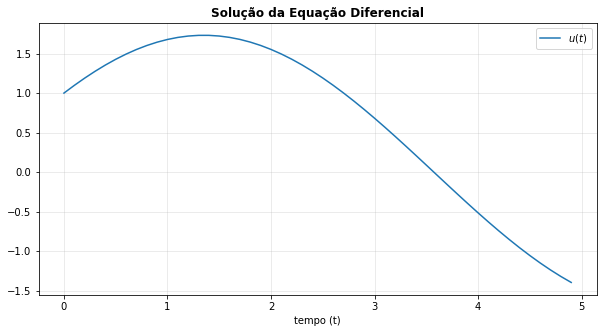

In [54]:
exibe_solucao_2(eq,[1,1])

$2y'' + y = 1$

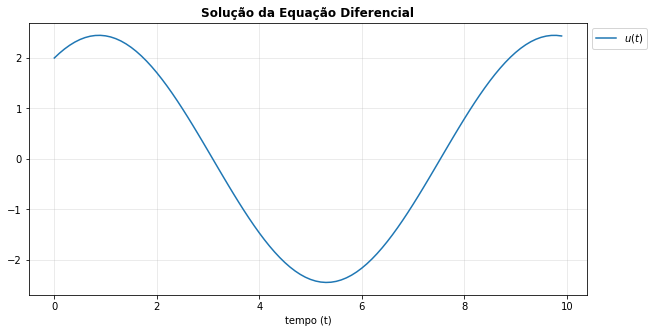

In [55]:
eq = [2,0,1,1]
c = [1,2]
exibe_solucao_2(eq,c, tf = 10)